In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [2]:
data = pd.read_pickle('../datasets/train_processed.pickle')

In [3]:
# getting data for model

X_t = data['question_titles'].values.copy()
X_q = data['questions'].values.copy()
X_a = data['answers'].values.copy()

In [4]:
X_t.shape, X_q.shape, X_a.shape

((6076,), (6076,), (6076,))

In [5]:
# padding to maximum length

X_t = keras.preprocessing.sequence.pad_sequences(X_t)
X_q = keras.preprocessing.sequence.pad_sequences(X_q)
X_a = keras.preprocessing.sequence.pad_sequences(X_a)

In [6]:
X_t.shape, X_q.shape, X_a.shape

((6076, 32), (6076, 500), (6076, 500))

In [7]:
target_names = data.columns[3:-3].copy()

y = data[data.columns[3:-3]].values.copy()
y.shape

(6076, 30)

In [8]:
# train test split
from sklearn.model_selection import train_test_split

X_t_train, X_t_test, y_train, y_test = train_test_split(X_t, y, test_size=0.2, random_state=42)
X_q_train, X_q_test, y_train, y_test = train_test_split(X_q, y, test_size=0.2, random_state=42)
X_a_train, X_a_test, y_train, y_test = train_test_split(X_a, y, test_size=0.2, random_state=42)

# Baseline model

Mean of each target feature as prediction, to compute MSEs.

In [9]:
means = []
for i in range(y_train.shape[1]):
    x = np.mean(y_train[:,i])
    array = []
    for j in range(len(y_test)):
        array.append(x)
    array = np.array(array)
    array = np.clip(array, 0 ,1)
    means.append(array)
                
means = np.array(means).T
means.shape

(1216, 30)

In [10]:
lens = []
for i in target_names:
    lens.append(len(i))
max(lens)

37

In [11]:
from scipy.stats import spearmanr
from sklearn.metrics import mean_squared_error as mse

def print_cors_mse(target_names, preds, reals):
    cors = []
    mses = []
    for i in range(len(target_names)):
        name = target_names[i]
        name = name + ':'
        if len(name)<40:
            name = name + ' '*(40-len(name))
        print(name, f'cor: {np.round(spearmanr(preds[:,i],reals[:,i]).correlation,3)},    mse: {np.round(mse(preds[:,i],reals[:,i]),3)}')
        cors.append(spearmanr(preds[:,i],reals[:,i]).correlation)
        mses.append(mse(preds[:,i],reals[:,i]))
    print('\n\n CORRELATION STATS: \n', pd.Series(cors).describe())
    print('\n\n MSE STATS: \n', pd.Series(mses).describe())

In [12]:
print_cors_mse(target_names, means, y_test)

question_asker_intent_understanding:     cor: nan,    mse: 0.017
question_body_critical:                  cor: nan,    mse: 0.048
question_conversational:                 cor: nan,    mse: 0.035
question_expect_short_answer:            cor: nan,    mse: 0.126
question_fact_seeking:                   cor: nan,    mse: 0.091
question_has_commonly_accepted_answer:   cor: nan,    mse: 0.117
question_interestingness_others:         cor: nan,    mse: 0.019
question_interestingness_self:           cor: nan,    mse: 0.035
question_multi_intent:                   cor: nan,    mse: 0.113
question_not_really_a_question:          cor: nan,    mse: 0.002
question_opinion_seeking:                cor: nan,    mse: 0.138
question_type_choice:                    cor: nan,    mse: 0.139
question_type_compare:                   cor: nan,    mse: 0.031
question_type_consequence:               cor: nan,    mse: 0.005
question_type_definition:                cor: nan,    mse: 0.021
question_type_entity:    

/usr/anaconda/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/anaconda/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/anaconda/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/anaconda/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/anaconda/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr/anaconda/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/anaconda/lib/python3.7/site-packages

In [12]:
def plot_cors_mse(target_names, preds, reals):
    cors = []
    mses = []
    for i in range(len(target_names)):
        cors.append(spearmanr(preds[:,i],reals[:,i]).correlation)
        mses.append(mse(preds[:,i],reals[:,i]))
    plt.figure(figsize=(20,7))
    plt.subplot(1,2,1)
    plt.bar(target_names, cors)
    plt.xticks(rotation=90)
    plt.title('CORS')
    plt.subplot(1,2,2)
    plt.bar(target_names, mses)
    plt.xticks(rotation=90)
    plt.title('MSEs')

# Bag of words model

In [13]:
# reading data
import pickle

with open('../datasets/tfidf_inputs.pickle', 'rb') as f:
    X_bow = pickle.load(f)

In [14]:
X_bow.shape

(6076, 8277)

In [15]:
X_bow_train, X_bow_test, y_train, y_test = train_test_split(X_bow, y, test_size=0.2, random_state=42)

In [16]:
# minmax layer

class min_max_scaler(keras.layers.Layer):
    def call(self,x):
        min_ = tf.reduce_min(x)
        max_ = tf.reduce_max(x)
        
        x = (x-min_)/(max_-min_)
        return x

In [18]:
# Multilayer perceptron
# hard sigmoid for 0-1 range

model = keras.models.Sequential()

model.add(keras.layers.Input(shape = X_bow_train.shape[1]))

model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(5000, activity_regularizer='l2', activation=keras.activations.swish))

model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(1000, activity_regularizer='l2', activation=keras.activations.swish))

model.add(keras.layers.Dense(30, activation='sigmoid'))

model.compile(optimizer = 'adam', loss = 'mse')

In [19]:
earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0005, patience=10, restore_best_weights=True)

In [20]:
# ideal batch size

0.03*len(X_bow_train)

145.79999999999998

In [22]:
history = model.fit(X_bow_train, y_train, batch_size=145, epochs=500, callbacks=[earlystopping], validation_data=(X_bow_test, y_test))

Epoch 1/500
34/34 [==============================] - 1s 33ms/step - loss: 0.0693 - val_loss: 0.0674
Epoch 2/500
34/34 [==============================] - 1s 32ms/step - loss: 0.0637 - val_loss: 0.0641
Epoch 3/500
34/34 [==============================] - 1s 33ms/step - loss: 0.0601 - val_loss: 0.0625
Epoch 4/500
34/34 [==============================] - 1s 33ms/step - loss: 0.0574 - val_loss: 0.0616
Epoch 5/500
34/34 [==============================] - 1s 33ms/step - loss: 0.0559 - val_loss: 0.0609
Epoch 6/500
34/34 [==============================] - 1s 30ms/step - loss: 0.0544 - val_loss: 0.0608
Epoch 7/500
34/34 [==============================] - 1s 33ms/step - loss: 0.0531 - val_loss: 0.0599
Epoch 8/500
34/34 [==============================] - 1s 30ms/step - loss: 0.0524 - val_loss: 0.0603
Epoch 9/500
34/34 [==============================] - 1s 30ms/step - loss: 0.0518 - val_loss: 0.0600
Epoch 10/500
34/34 [==============================] - 1s 28ms/step - loss: 0.0515 - val_loss: 0.0600

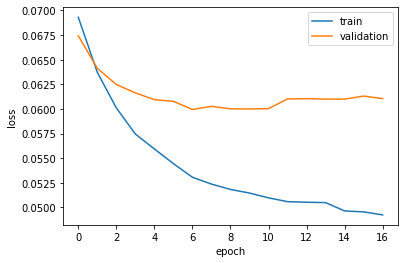

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])

In [24]:
preds_train = model.predict(X_bow_train)

In [25]:
preds_test = model.predict(X_bow_test)

In [26]:
print_cors_mse(target_names, preds_test, y_test)

question_asker_intent_understanding:     cor: 0.19,    mse: 0.017
question_body_critical:                  cor: 0.438,    mse: 0.039
question_conversational:                 cor: 0.382,    mse: 0.031
question_expect_short_answer:            cor: 0.176,    mse: 0.122
question_fact_seeking:                   cor: 0.28,    mse: 0.078
question_has_commonly_accepted_answer:   cor: 0.345,    mse: 0.093
question_interestingness_others:         cor: 0.317,    mse: 0.017
question_interestingness_self:           cor: 0.404,    mse: 0.029
question_multi_intent:                   cor: 0.31,    mse: 0.102
question_not_really_a_question:          cor: 0.008,    mse: 0.007
question_opinion_seeking:                cor: 0.341,    mse: 0.121
question_type_choice:                    cor: 0.467,    mse: 0.11
question_type_compare:                   cor: 0.174,    mse: 0.031
question_type_consequence:               cor: 0.055,    mse: 0.01
question_type_definition:                cor: 0.15,    mse: 0.023
q

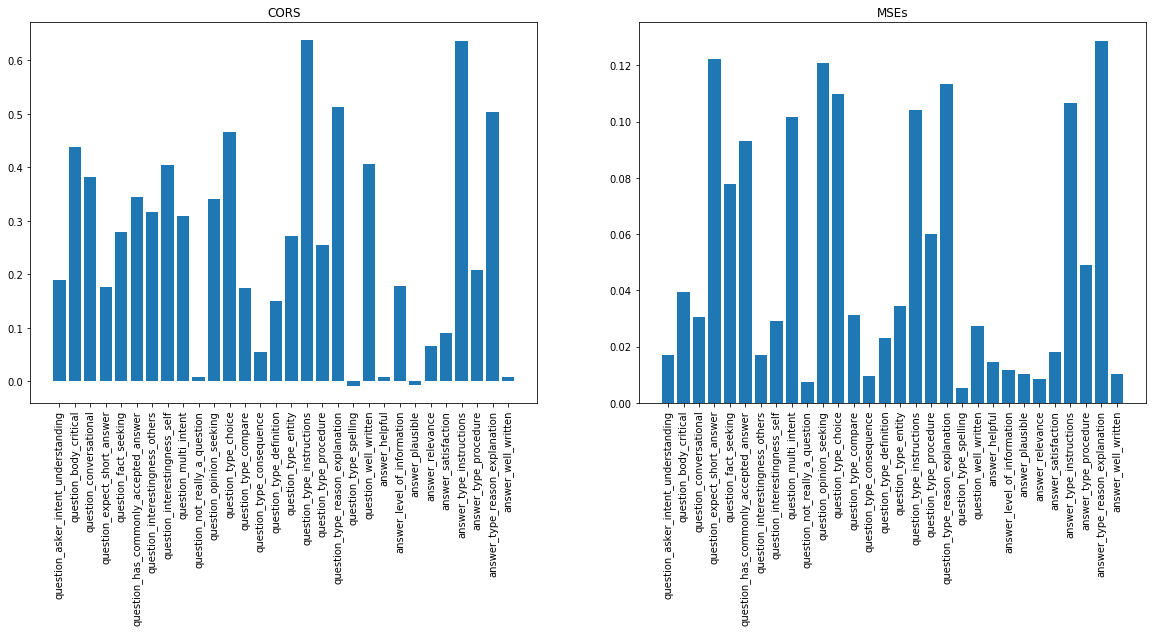

In [27]:
plot_cors_mse(target_names, preds_test, y_test)

In [28]:
# scatterplots

def scatterplots(target_names, preds, reals):
    plt.figure(figsize=(25,35))
    for i in range(len(target_names)):
        plt.subplot(10,3,i+1)
        plt.scatter(preds[:,i],reals[:,i])
        plt.title(target_names[i])
        plt.tight_layout()
    plt.show()

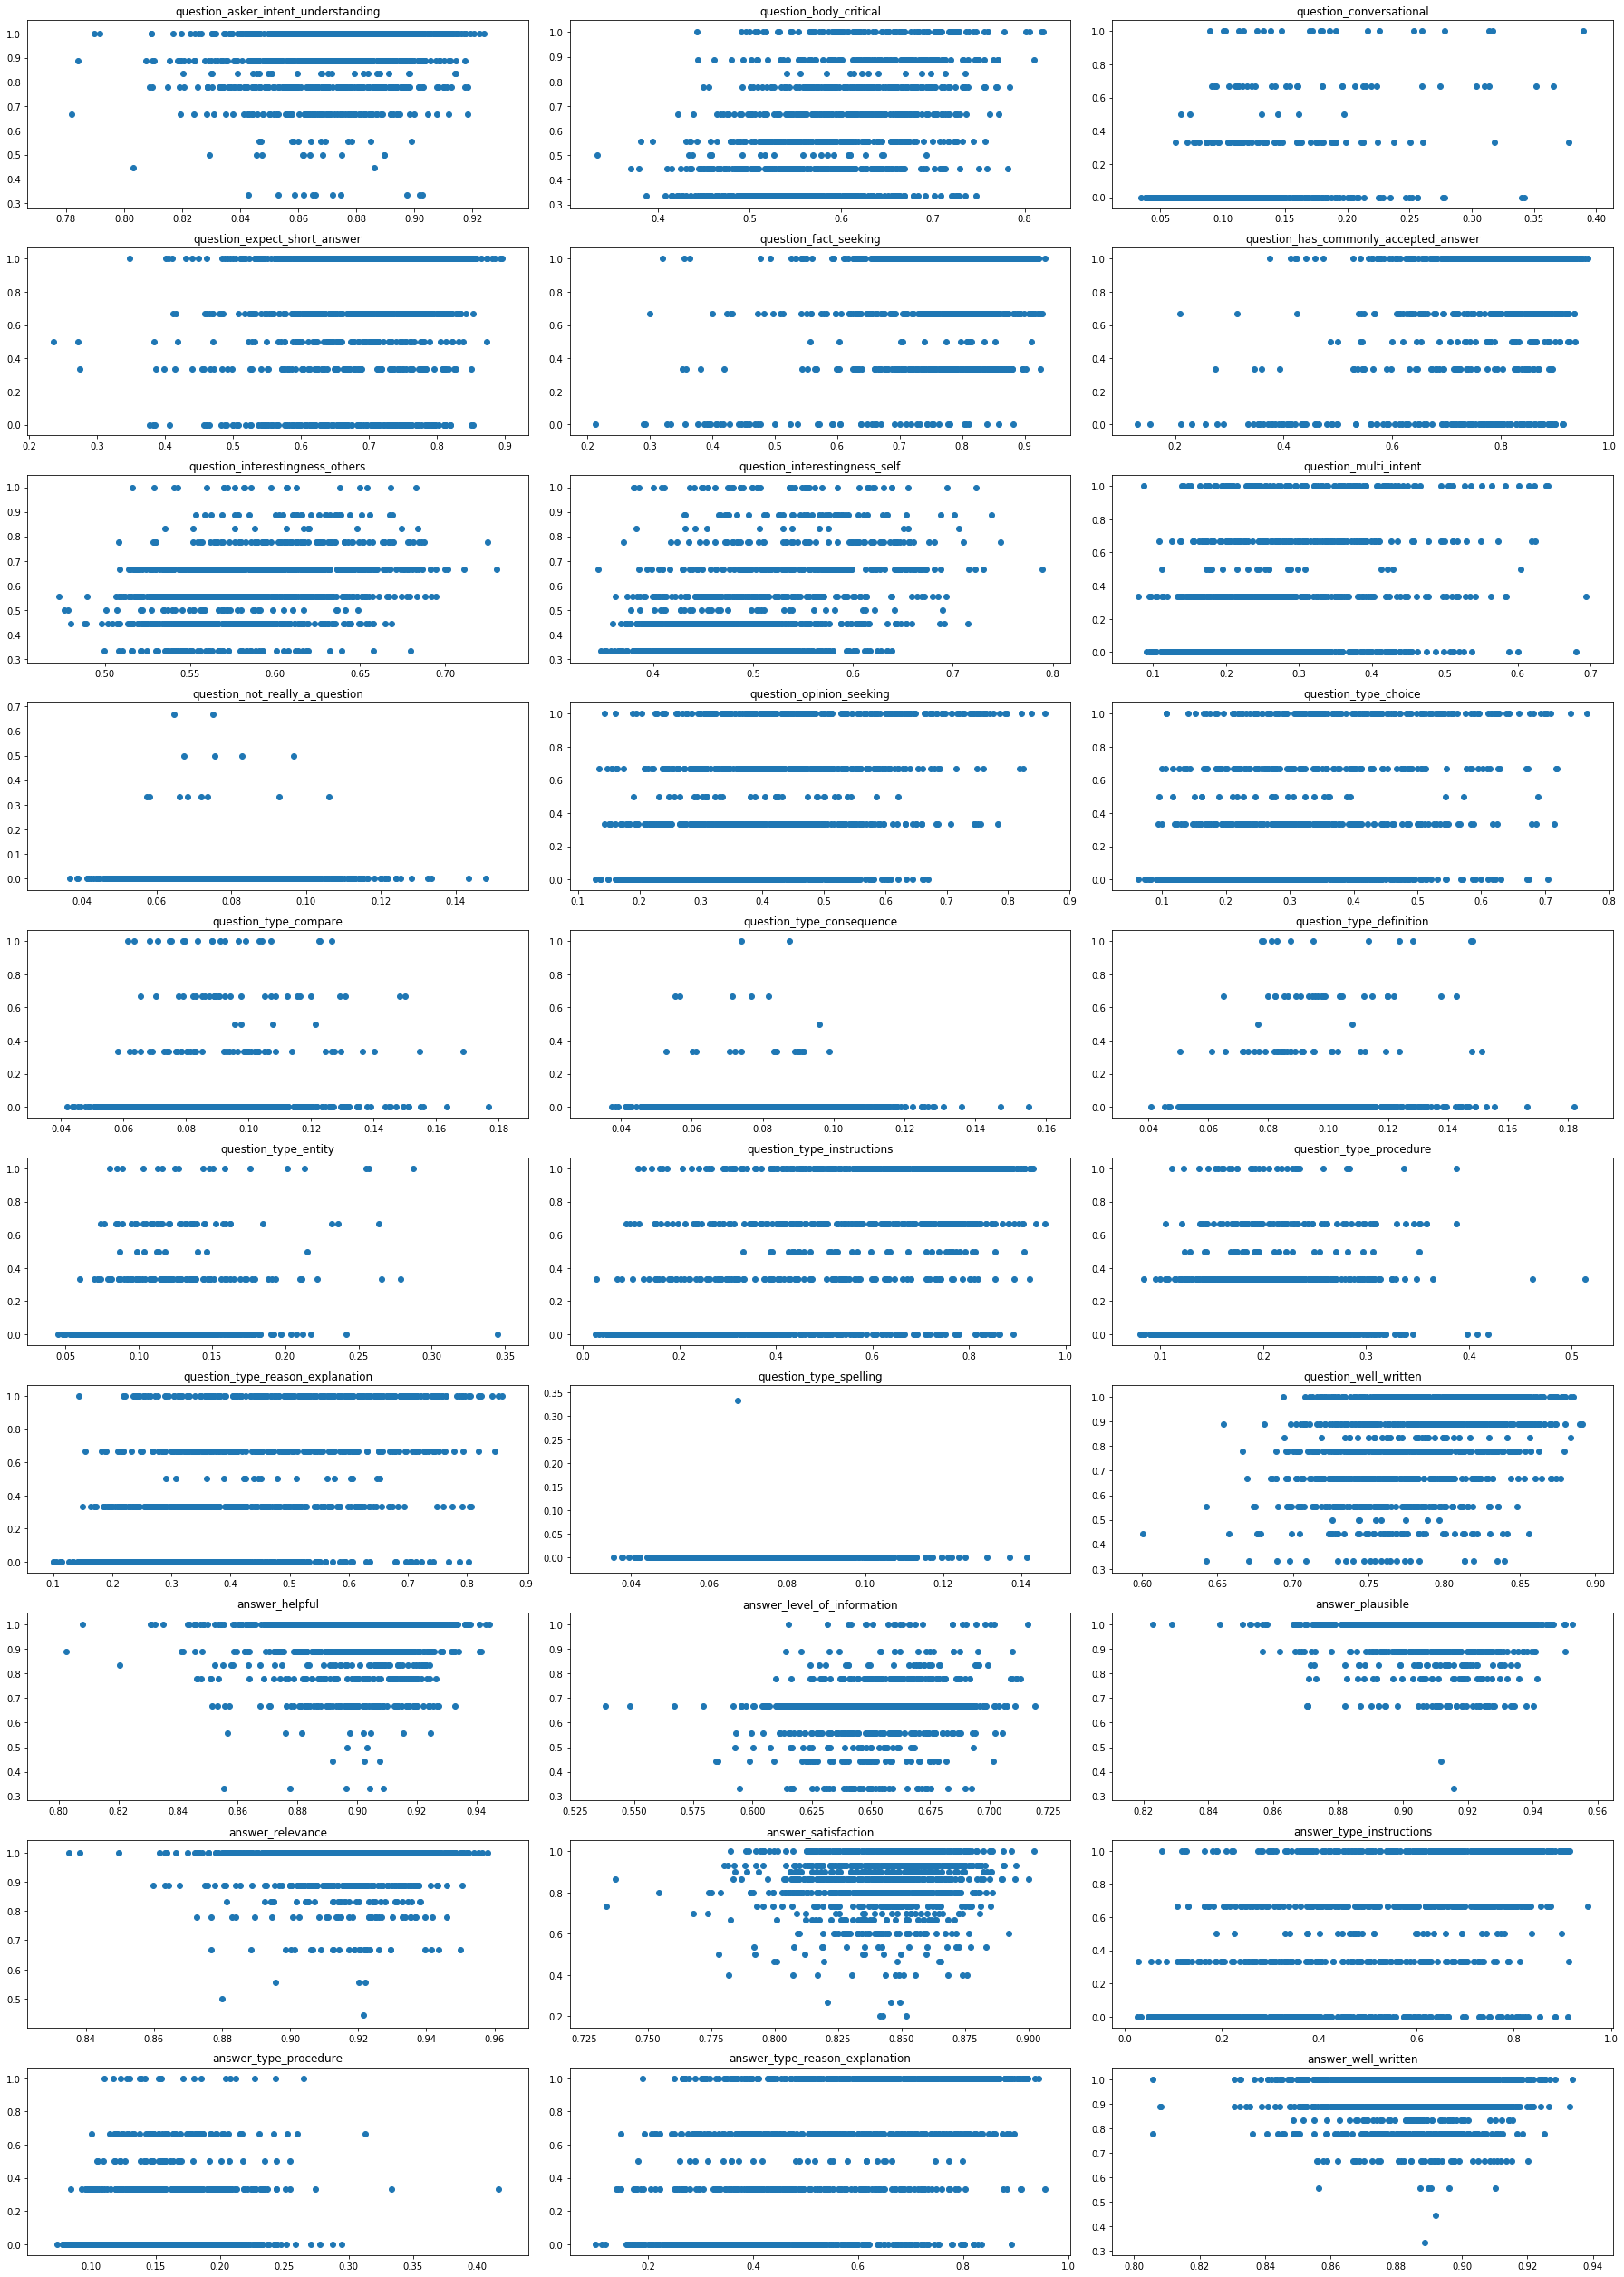

In [29]:
scatterplots(target_names, preds_test, y_test)

# LSTM Model

Not able to outperform BOW model. Probably because of own embeddings. Embeddings are huge set of weights which is hard to train, here it probably remains very stohastic.

In [16]:
X_t_train.shape, X_q_train.shape, X_a_train.shape

((4860, 32), (4860, 500), (4860, 500))

In [21]:
embedding = keras.layers.Embedding(8277, 128)

input_t = keras.layers.Input(shape=32)
x_t = embedding(input_t)
x_t = keras.layers.Masking()(x_t)
x_t = keras.layers.Bidirectional(keras.layers.LSTM(64, dropout=0.3))(x_t)

input_q = keras.layers.Input(shape=500)
x_q = embedding(input_q)
x_q = keras.layers.Masking()(x_q)
x_q = keras.layers.Bidirectional(keras.layers.LSTM(128, dropout=0.3))(x_q)

input_a = keras.layers.Input(shape=500)
x_a = embedding(input_a)
x_a = keras.layers.Masking()(x_a)
x_a = keras.layers.Bidirectional(keras.layers.LSTM(128, dropout=0.3))(x_a)

x = keras.layers.concatenate((x_t, x_q, x_a))

x = keras.layers.Dropout(0.3)(x)
x = keras.layers.Dense(100, activity_regularizer='l2', activation=keras.activations.swish)(x)

output = keras.layers.Dense(30, activation=keras.activations.hard_sigmoid)(x)

model = keras.Model([input_t, input_q, input_a], output)

model.compile(optimizer = 'adam', loss = 'mse')

In [22]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 32)]         0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 500)]        0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         multiple             1059456     input_4[0][0]                    
                                                                 input_5[0][0]         

In [23]:
history = model.fit([X_t_train, X_q_train, X_a_train], y_train, batch_size=145, epochs=500, callbacks=[earlystopping], validation_data=([X_t_test, X_q_test, X_a_test], y_test))

Epoch 1/500
34/34 [==============================] - 17s 496ms/step - loss: 0.1433 - val_loss: 0.1221
Epoch 2/500
34/34 [==============================] - 13s 380ms/step - loss: 0.1078 - val_loss: 0.0969
Epoch 3/500
34/34 [==============================] - 13s 380ms/step - loss: 0.0894 - val_loss: 0.0849
Epoch 4/500
34/34 [==============================] - 13s 380ms/step - loss: 0.0791 - val_loss: 0.0779
Epoch 5/500
34/34 [==============================] - 13s 382ms/step - loss: 0.0722 - val_loss: 0.0737
Epoch 6/500
34/34 [==============================] - 13s 379ms/step - loss: 0.0672 - val_loss: 0.0705
Epoch 7/500
34/34 [==============================] - 13s 380ms/step - loss: 0.0632 - val_loss: 0.0682
Epoch 8/500
34/34 [==============================] - 13s 381ms/step - loss: 0.0600 - val_loss: 0.0669
Epoch 9/500
34/34 [==============================] - 13s 380ms/step - loss: 0.0572 - val_loss: 0.0652
Epoch 10/500
34/34 [==============================] - 13s 382ms/step - loss: 0.054

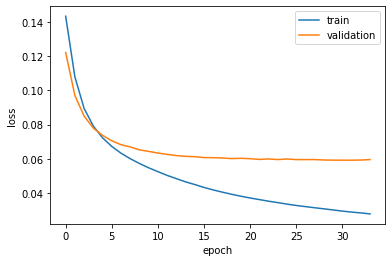

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])

In [25]:
preds_train = model.predict([X_t_train, X_q_train, X_a_train])
preds_test = model.predict([X_t_test, X_q_test, X_a_test])

In [26]:
print_cors_mse(target_names, preds_test, y_test)

question_asker_intent_understanding:     cor: 0.185,    mse: 0.017
question_body_critical:                  cor: 0.559,    mse: 0.033
question_conversational:                 cor: 0.323,    mse: 0.028
question_expect_short_answer:            cor: 0.198,    mse: 0.129
question_fact_seeking:                   cor: 0.271,    mse: 0.086
question_has_commonly_accepted_answer:   cor: 0.305,    mse: 0.098
question_interestingness_others:         cor: 0.319,    mse: 0.017
question_interestingness_self:           cor: 0.352,    mse: 0.031
question_multi_intent:                   cor: 0.375,    mse: 0.097
question_not_really_a_question:          cor: -0.008,    mse: 0.003
question_opinion_seeking:                cor: 0.337,    mse: 0.133
question_type_choice:                    cor: 0.557,    mse: 0.096
question_type_compare:                   cor: 0.243,    mse: 0.029
question_type_consequence:               cor: 0.078,    mse: 0.006
question_type_definition:                cor: 0.241,    mse: 

In [27]:
print_cors_mse(target_names, preds_train, y_train)

question_asker_intent_understanding:     cor: 0.432,    mse: 0.015
question_body_critical:                  cor: 0.759,    mse: 0.022
question_conversational:                 cor: 0.467,    mse: 0.02
question_expect_short_answer:            cor: 0.842,    mse: 0.036
question_fact_seeking:                   cor: 0.82,    mse: 0.028
question_has_commonly_accepted_answer:   cor: 0.731,    mse: 0.045
question_interestingness_others:         cor: 0.393,    mse: 0.015
question_interestingness_self:           cor: 0.561,    mse: 0.023
question_multi_intent:                   cor: 0.796,    mse: 0.039
question_not_really_a_question:          cor: 0.072,    mse: 0.003
question_opinion_seeking:                cor: 0.917,    mse: 0.026
question_type_choice:                    cor: 0.869,    mse: 0.032
question_type_compare:                   cor: 0.295,    mse: 0.02
question_type_consequence:               cor: 0.108,    mse: 0.006
question_type_definition:                cor: 0.304,    mse: 0.01

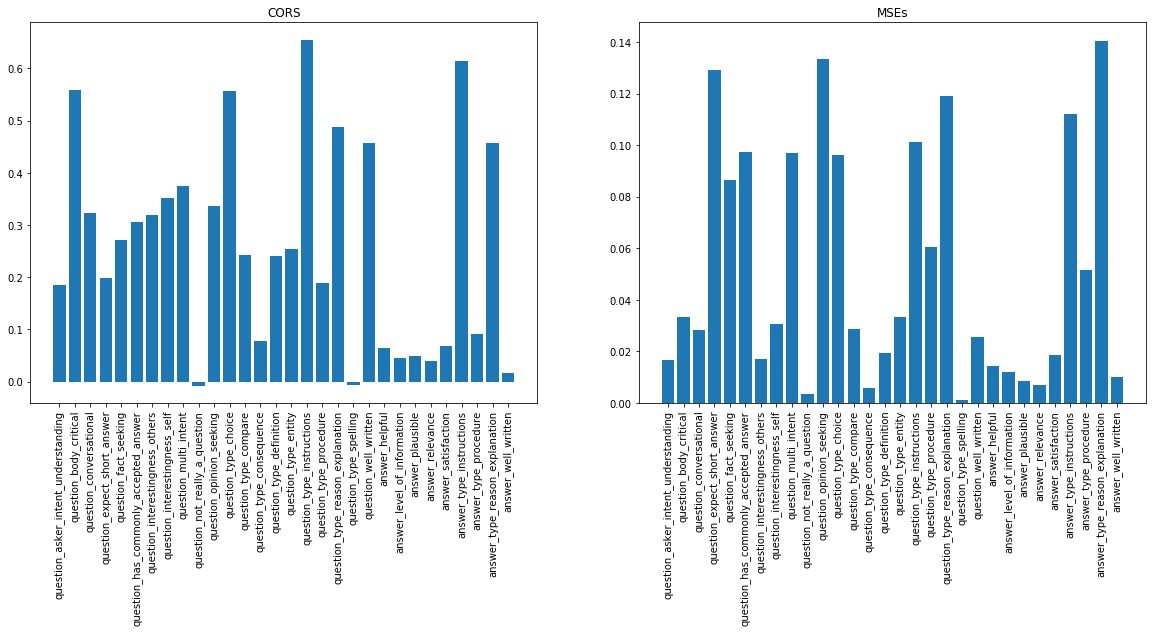

In [28]:
plot_cors_mse(target_names, preds_test, y_test)

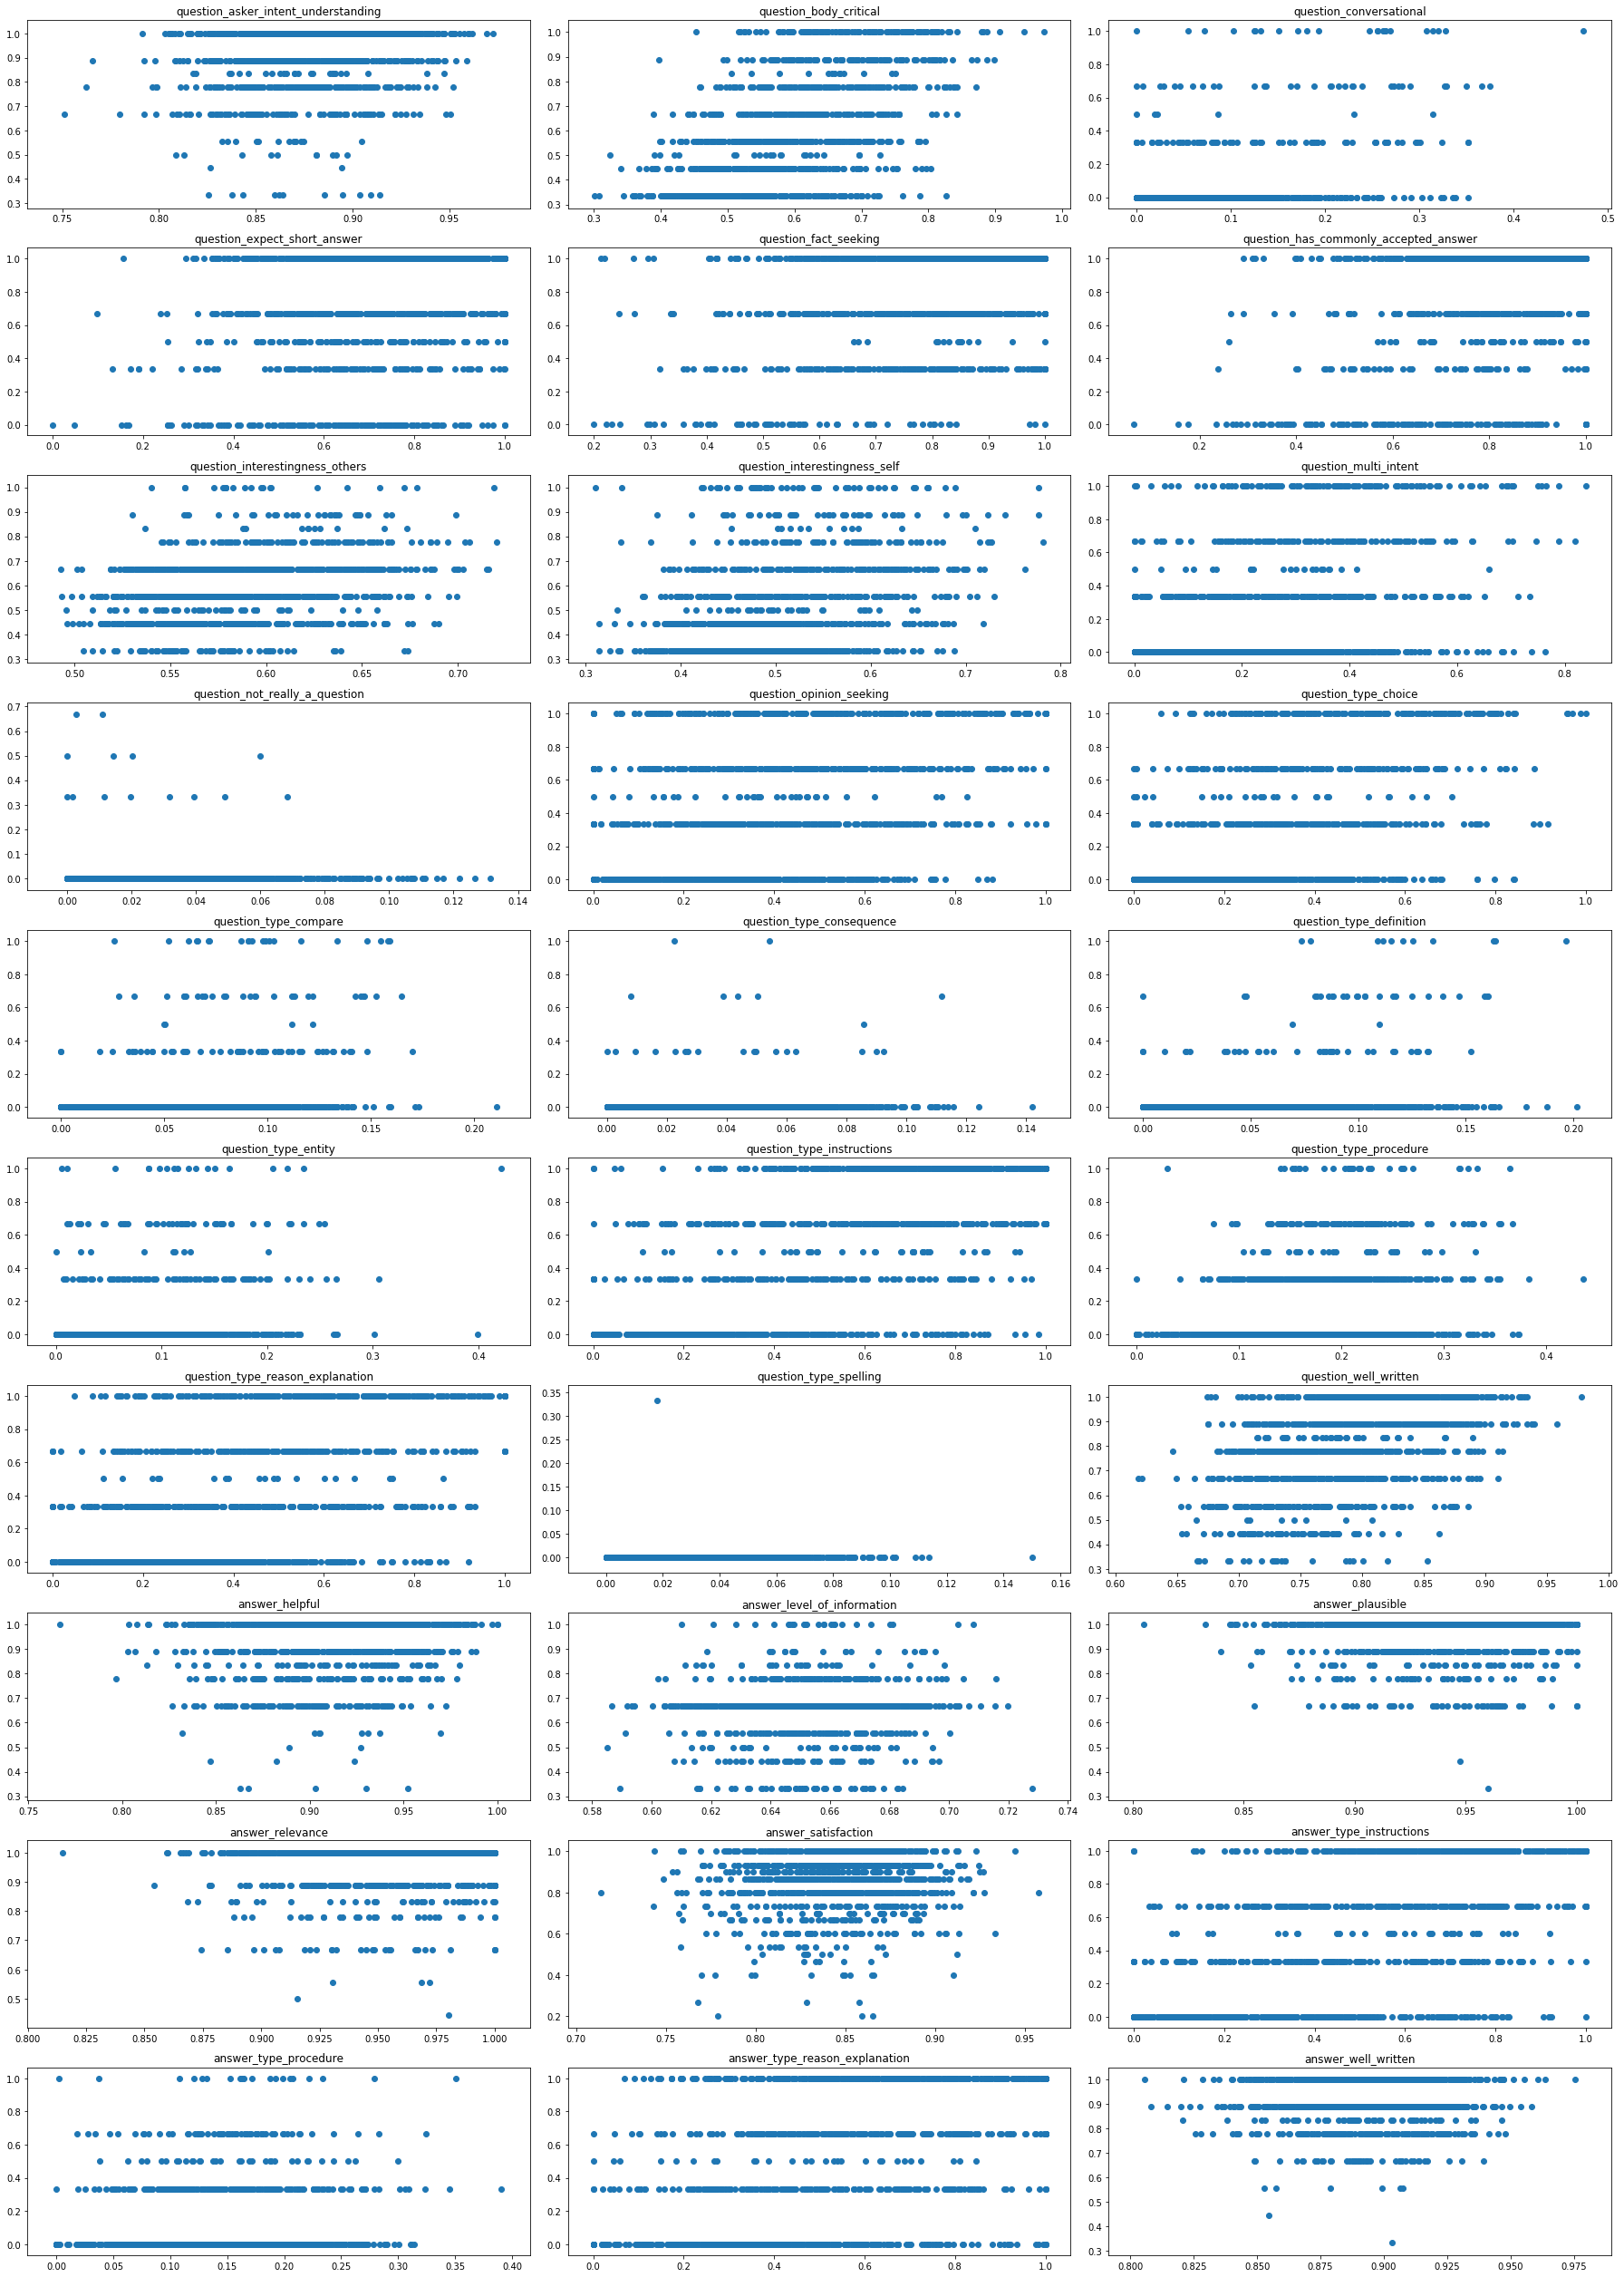

In [29]:
scatterplots(target_names, preds_test, y_test)

# Adding attention layer before LSTM

Luong style, performing self attention on questions and answers. This way, input embeddings get contextualized.

In [60]:
embedding = keras.layers.Embedding(8277, 64)

input_q = keras.layers.Input(shape=500)
x_q = embedding(input_q)
x_q = keras.layers.Attention()([x_q,x_q])
x_q = keras.layers.Bidirectional(keras.layers.LSTM(64, dropout=0.3))(x_q)

input_a = keras.layers.Input(shape=500)
x_a = embedding(input_a)
x_a = keras.layers.Attention()([x_a,x_a])
x_a = keras.layers.Bidirectional(keras.layers.LSTM(64, dropout=0.3))(x_a)

x = keras.layers.concatenate((x_q, x_a))

x = keras.layers.Dense(64, activity_regularizer='l2')(x)
x = keras.layers.LeakyReLU(0.5)(x)
output = keras.layers.Dense(30, activation=keras.activations.hard_sigmoid)(x)

model = keras.Model([input_q, input_a], output)

model.compile(optimizer = 'adam', loss = 'mse')

In [61]:
model.summary()

Model: "functional_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           [(None, 500)]        0                                            
__________________________________________________________________________________________________
input_24 (InputLayer)           [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding_12 (Embedding)        (None, 500, 64)      529728      input_23[0][0]                   
                                                                 input_24[0][0]                   
__________________________________________________________________________________________________
attention_1 (Attention)         (None, 500, 64)      0           embedding_12[0][0]   

In [62]:
model.fit([X_q_train, X_a_train], y_train, batch_size=145, epochs=500, callbacks=[earlystopping], validation_data=([X_q_test, X_a_test], y_test))

Epoch 1/500
34/34 [==============================] - 9s 259ms/step - loss: 0.1508 - val_loss: 0.1360
Epoch 2/500
34/34 [==============================] - 8s 237ms/step - loss: 0.1230 - val_loss: 0.1127
Epoch 3/500
34/34 [==============================] - 8s 240ms/step - loss: 0.1045 - val_loss: 0.0990
Epoch 4/500
34/34 [==============================] - 8s 236ms/step - loss: 0.0938 - val_loss: 0.0909
Epoch 5/500
34/34 [==============================] - 8s 237ms/step - loss: 0.0870 - val_loss: 0.0856
Epoch 6/500
34/34 [==============================] - 8s 241ms/step - loss: 0.0821 - val_loss: 0.0811
Epoch 7/500
34/34 [==============================] - 8s 240ms/step - loss: 0.0780 - val_loss: 0.0778
Epoch 8/500
34/34 [==============================] - 8s 241ms/step - loss: 0.0747 - val_loss: 0.0751
Epoch 9/500
34/34 [==============================] - 8s 237ms/step - loss: 0.0717 - val_loss: 0.0720
Epoch 10/500
34/34 [==============================] - 8s 235ms/step - loss: 0.0688 - val_lo

In [63]:
preds_train = model.predict([X_q_train, X_a_train])
preds_test = model.predict([X_q_test, X_a_test])

In [64]:
print_cors_mse(target_names, preds_test, y_test)

question_asker_intent_understanding:     cor: 0.085,    mse: 0.018
question_body_critical:                  cor: 0.36,    mse: 0.042
question_conversational:                 cor: 0.37,    mse: 0.03
question_expect_short_answer:            cor: 0.202,    mse: 0.119
question_fact_seeking:                   cor: 0.233,    mse: 0.082
question_has_commonly_accepted_answer:   cor: 0.344,    mse: 0.097
question_interestingness_others:         cor: 0.301,    mse: 0.017
question_interestingness_self:           cor: 0.385,    mse: 0.03
question_multi_intent:                   cor: 0.321,    mse: 0.1
question_not_really_a_question:          cor: 0.015,    mse: 0.006
question_opinion_seeking:                cor: 0.342,    mse: 0.121
question_type_choice:                    cor: 0.268,    mse: 0.13
question_type_compare:                   cor: 0.253,    mse: 0.029
question_type_consequence:               cor: 0.038,    mse: 0.008
question_type_definition:                cor: 0.149,    mse: 0.023
qu

In [65]:
print_cors_mse(target_names, preds_train, y_train)

question_asker_intent_understanding:     cor: 0.192,    mse: 0.017
question_body_critical:                  cor: 0.451,    mse: 0.039
question_conversational:                 cor: 0.424,    mse: 0.025
question_expect_short_answer:            cor: 0.427,    mse: 0.105
question_fact_seeking:                   cor: 0.424,    mse: 0.074
question_has_commonly_accepted_answer:   cor: 0.566,    mse: 0.078
question_interestingness_others:         cor: 0.312,    mse: 0.017
question_interestingness_self:           cor: 0.411,    mse: 0.029
question_multi_intent:                   cor: 0.481,    mse: 0.088
question_not_really_a_question:          cor: 0.05,    mse: 0.006
question_opinion_seeking:                cor: 0.651,    mse: 0.09
question_type_choice:                    cor: 0.392,    mse: 0.116
question_type_compare:                   cor: 0.249,    mse: 0.022
question_type_consequence:               cor: 0.109,    mse: 0.008
question_type_definition:                cor: 0.176,    mse: 0.0

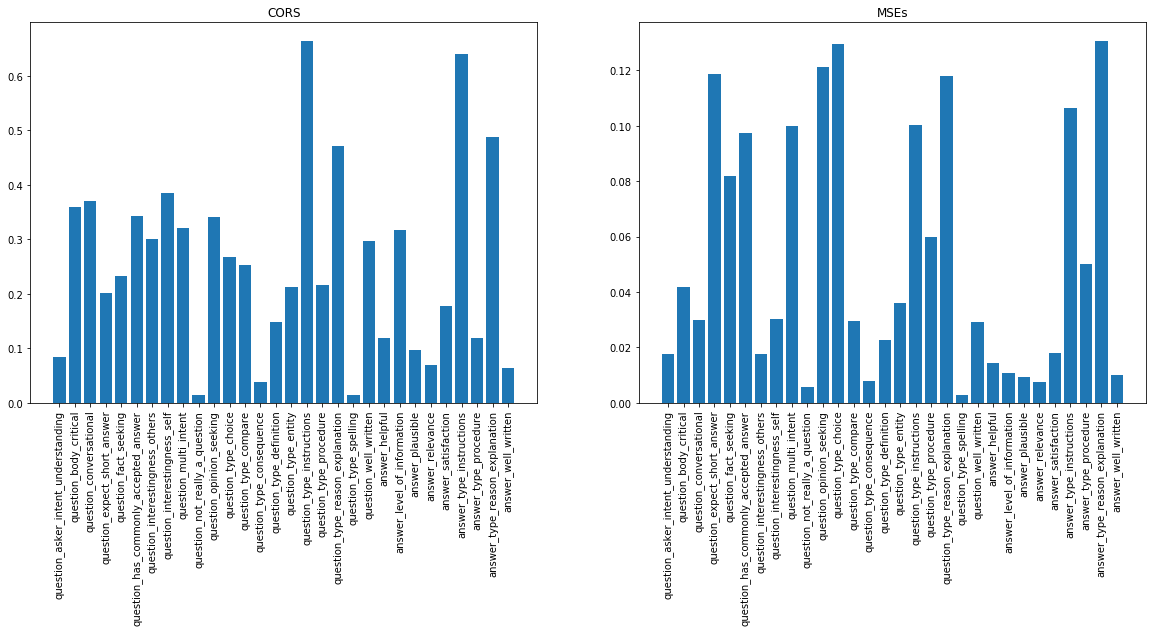

In [67]:
plot_cors_mse(target_names, preds_test, y_test)

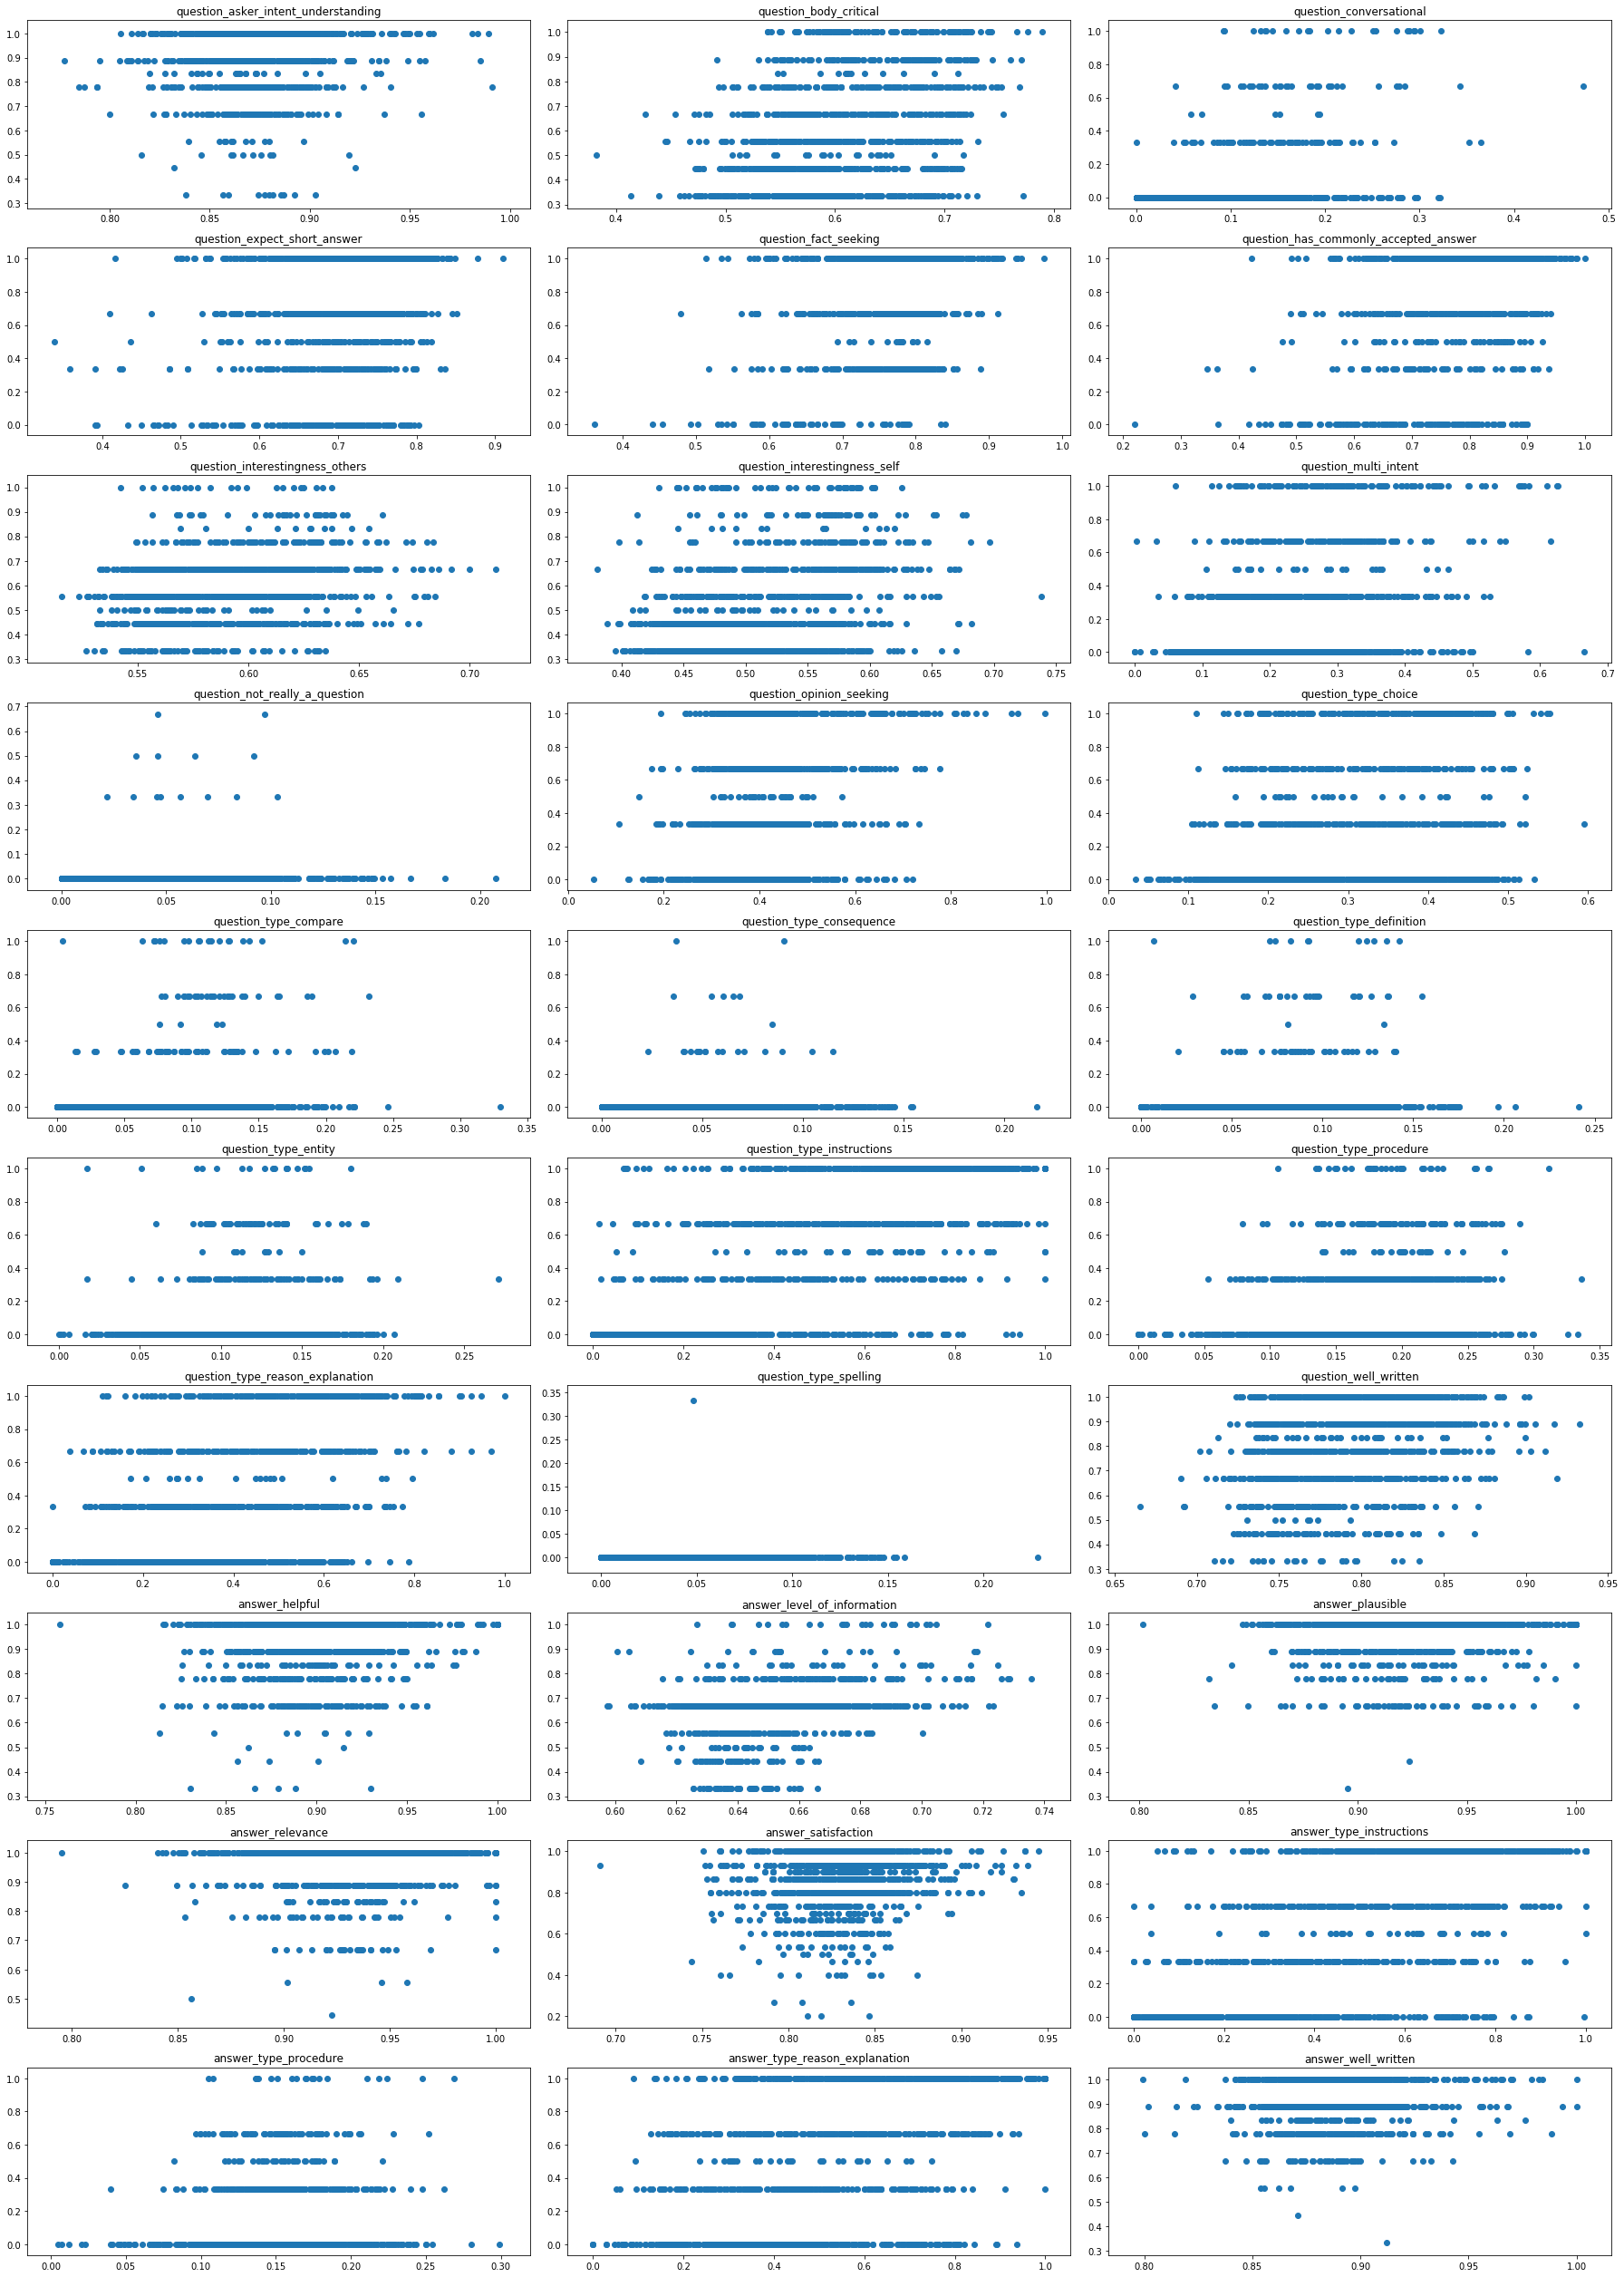

In [68]:
scatterplots(target_names, preds_test, y_test)

# Using sequences from LSTMs

Self attention. But, we need to put time distributed data in just one point, to get predictions. So, adding custom attention layer, which takes all time ponts, and returns their weighted sum. This result is then used in further modeling (many:1 relation).

In [74]:
import tensorflow.keras.backend as K

class attention_many_to_one(keras.layers.Layer):

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")        
        #super().build(input_shape)

    def call(self,x):
        # like time-distributed dense
        # each time point has n features
        # takes dot of features with weights (weights have dim n)
        # returns vector of len t - for each timepoint, just one value is returned
        # squeezed from (t,1) to t
        dots=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        softmax_weights=K.softmax(dots)
        softmax_weights=K.expand_dims(softmax_weights,axis=-1)
        # each time point is miltiplied by corresponding scalar
        # this gives greater weight to more important words in output sequence
        output=x*softmax_weights
        # all t time ponts are summed to get just one vector of dim n
        return K.sum(output,axis=1)

In [83]:
embedding = keras.layers.Embedding(8277, 64)

input_q = keras.layers.Input(shape=500)
x_q = embedding(input_q)
x_q = keras.layers.Attention()([x_q,x_q])
x_q = keras.layers.Bidirectional(keras.layers.LSTM(64, dropout=0.3, return_sequences=True))(x_q)
x_q = attention_many_to_one()(x_q)

input_a = keras.layers.Input(shape=500)
x_a = embedding(input_a)
x_a = keras.layers.Attention()([x_a,x_a])
x_a = keras.layers.Bidirectional(keras.layers.LSTM(64, dropout=0.3, return_sequences=True))(x_a)
x_a = attention_many_to_one()(x_a)

x = keras.layers.concatenate((x_q, x_a))

x = keras.layers.Dense(64, activity_regularizer='l2')(x)
x = keras.layers.LeakyReLU(0.5)(x)
output = keras.layers.Dense(30, activation=keras.activations.hard_sigmoid)(x)

model = keras.Model([input_q, input_a], output)

model.compile(optimizer = 'adam', loss = 'mse')

In [84]:
model.summary()

Model: "functional_27"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_35 (InputLayer)           [(None, 500)]        0                                            
__________________________________________________________________________________________________
input_36 (InputLayer)           [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding_19 (Embedding)        (None, 500, 64)      529728      input_35[0][0]                   
                                                                 input_36[0][0]                   
__________________________________________________________________________________________________
attention_13 (Attention)        (None, 500, 64)      0           embedding_19[0][0]   

In [85]:
model.fit([X_q_train, X_a_train], y_train, batch_size=145, epochs=500, callbacks=[earlystopping], validation_data=([X_q_test, X_a_test], y_test))

Epoch 1/500
34/34 [==============================] - 10s 287ms/step - loss: 0.1538 - val_loss: 0.1395
Epoch 2/500
34/34 [==============================] - 8s 245ms/step - loss: 0.1264 - val_loss: 0.1159
Epoch 3/500
34/34 [==============================] - 8s 246ms/step - loss: 0.1073 - val_loss: 0.1015
Epoch 4/500
34/34 [==============================] - 8s 247ms/step - loss: 0.0960 - val_loss: 0.0927
Epoch 5/500
34/34 [==============================] - 8s 243ms/step - loss: 0.0888 - val_loss: 0.0871
Epoch 6/500
34/34 [==============================] - 9s 254ms/step - loss: 0.0837 - val_loss: 0.0828
Epoch 7/500
34/34 [==============================] - 9s 255ms/step - loss: 0.0797 - val_loss: 0.0791
Epoch 8/500
34/34 [==============================] - 9s 255ms/step - loss: 0.0761 - val_loss: 0.0761
Epoch 9/500
34/34 [==============================] - 9s 257ms/step - loss: 0.0733 - val_loss: 0.0740
Epoch 10/500
34/34 [==============================] - 9s 252ms/step - loss: 0.0703 - val_l

In [86]:
preds_train = model.predict([X_q_train, X_a_train])
preds_test = model.predict([X_q_test, X_a_test])

In [87]:
print_cors_mse(target_names, preds_test, y_test)

question_asker_intent_understanding:     cor: 0.11,    mse: 0.018
question_body_critical:                  cor: 0.351,    mse: 0.043
question_conversational:                 cor: 0.368,    mse: 0.031
question_expect_short_answer:            cor: 0.154,    mse: 0.121
question_fact_seeking:                   cor: 0.239,    mse: 0.083
question_has_commonly_accepted_answer:   cor: 0.35,    mse: 0.099
question_interestingness_others:         cor: 0.306,    mse: 0.018
question_interestingness_self:           cor: 0.363,    mse: 0.031
question_multi_intent:                   cor: 0.302,    mse: 0.102
question_not_really_a_question:          cor: 0.017,    mse: 0.007
question_opinion_seeking:                cor: 0.353,    mse: 0.123
question_type_choice:                    cor: 0.256,    mse: 0.131
question_type_compare:                   cor: 0.199,    mse: 0.031
question_type_consequence:               cor: 0.044,    mse: 0.009
question_type_definition:                cor: 0.133,    mse: 0.0

In [88]:
print_cors_mse(target_names, preds_train, y_train)

question_asker_intent_understanding:     cor: 0.231,    mse: 0.018
question_body_critical:                  cor: 0.374,    mse: 0.042
question_conversational:                 cor: 0.413,    mse: 0.027
question_expect_short_answer:            cor: 0.322,    mse: 0.112
question_fact_seeking:                   cor: 0.411,    mse: 0.078
question_has_commonly_accepted_answer:   cor: 0.5,    mse: 0.086
question_interestingness_others:         cor: 0.297,    mse: 0.017
question_interestingness_self:           cor: 0.389,    mse: 0.03
question_multi_intent:                   cor: 0.431,    mse: 0.095
question_not_really_a_question:          cor: 0.042,    mse: 0.007
question_opinion_seeking:                cor: 0.586,    mse: 0.104
question_type_choice:                    cor: 0.364,    mse: 0.119
question_type_compare:                   cor: 0.208,    mse: 0.023
question_type_consequence:               cor: 0.063,    mse: 0.01
question_type_definition:                cor: 0.186,    mse: 0.02


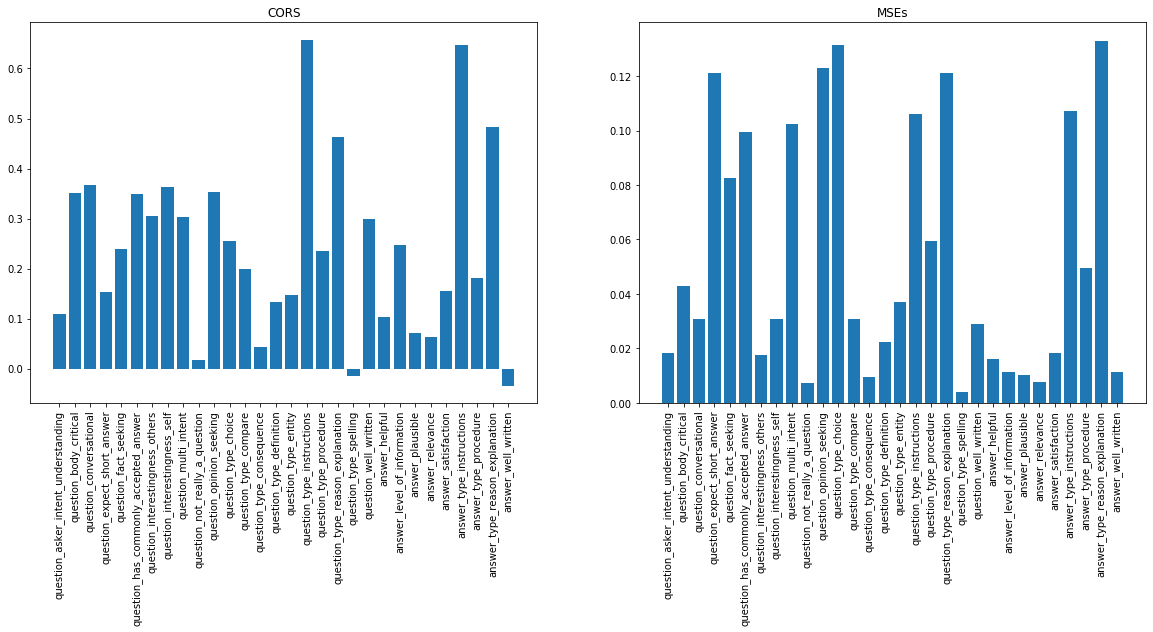

In [89]:
plot_cors_mse(target_names, preds_test, y_test)

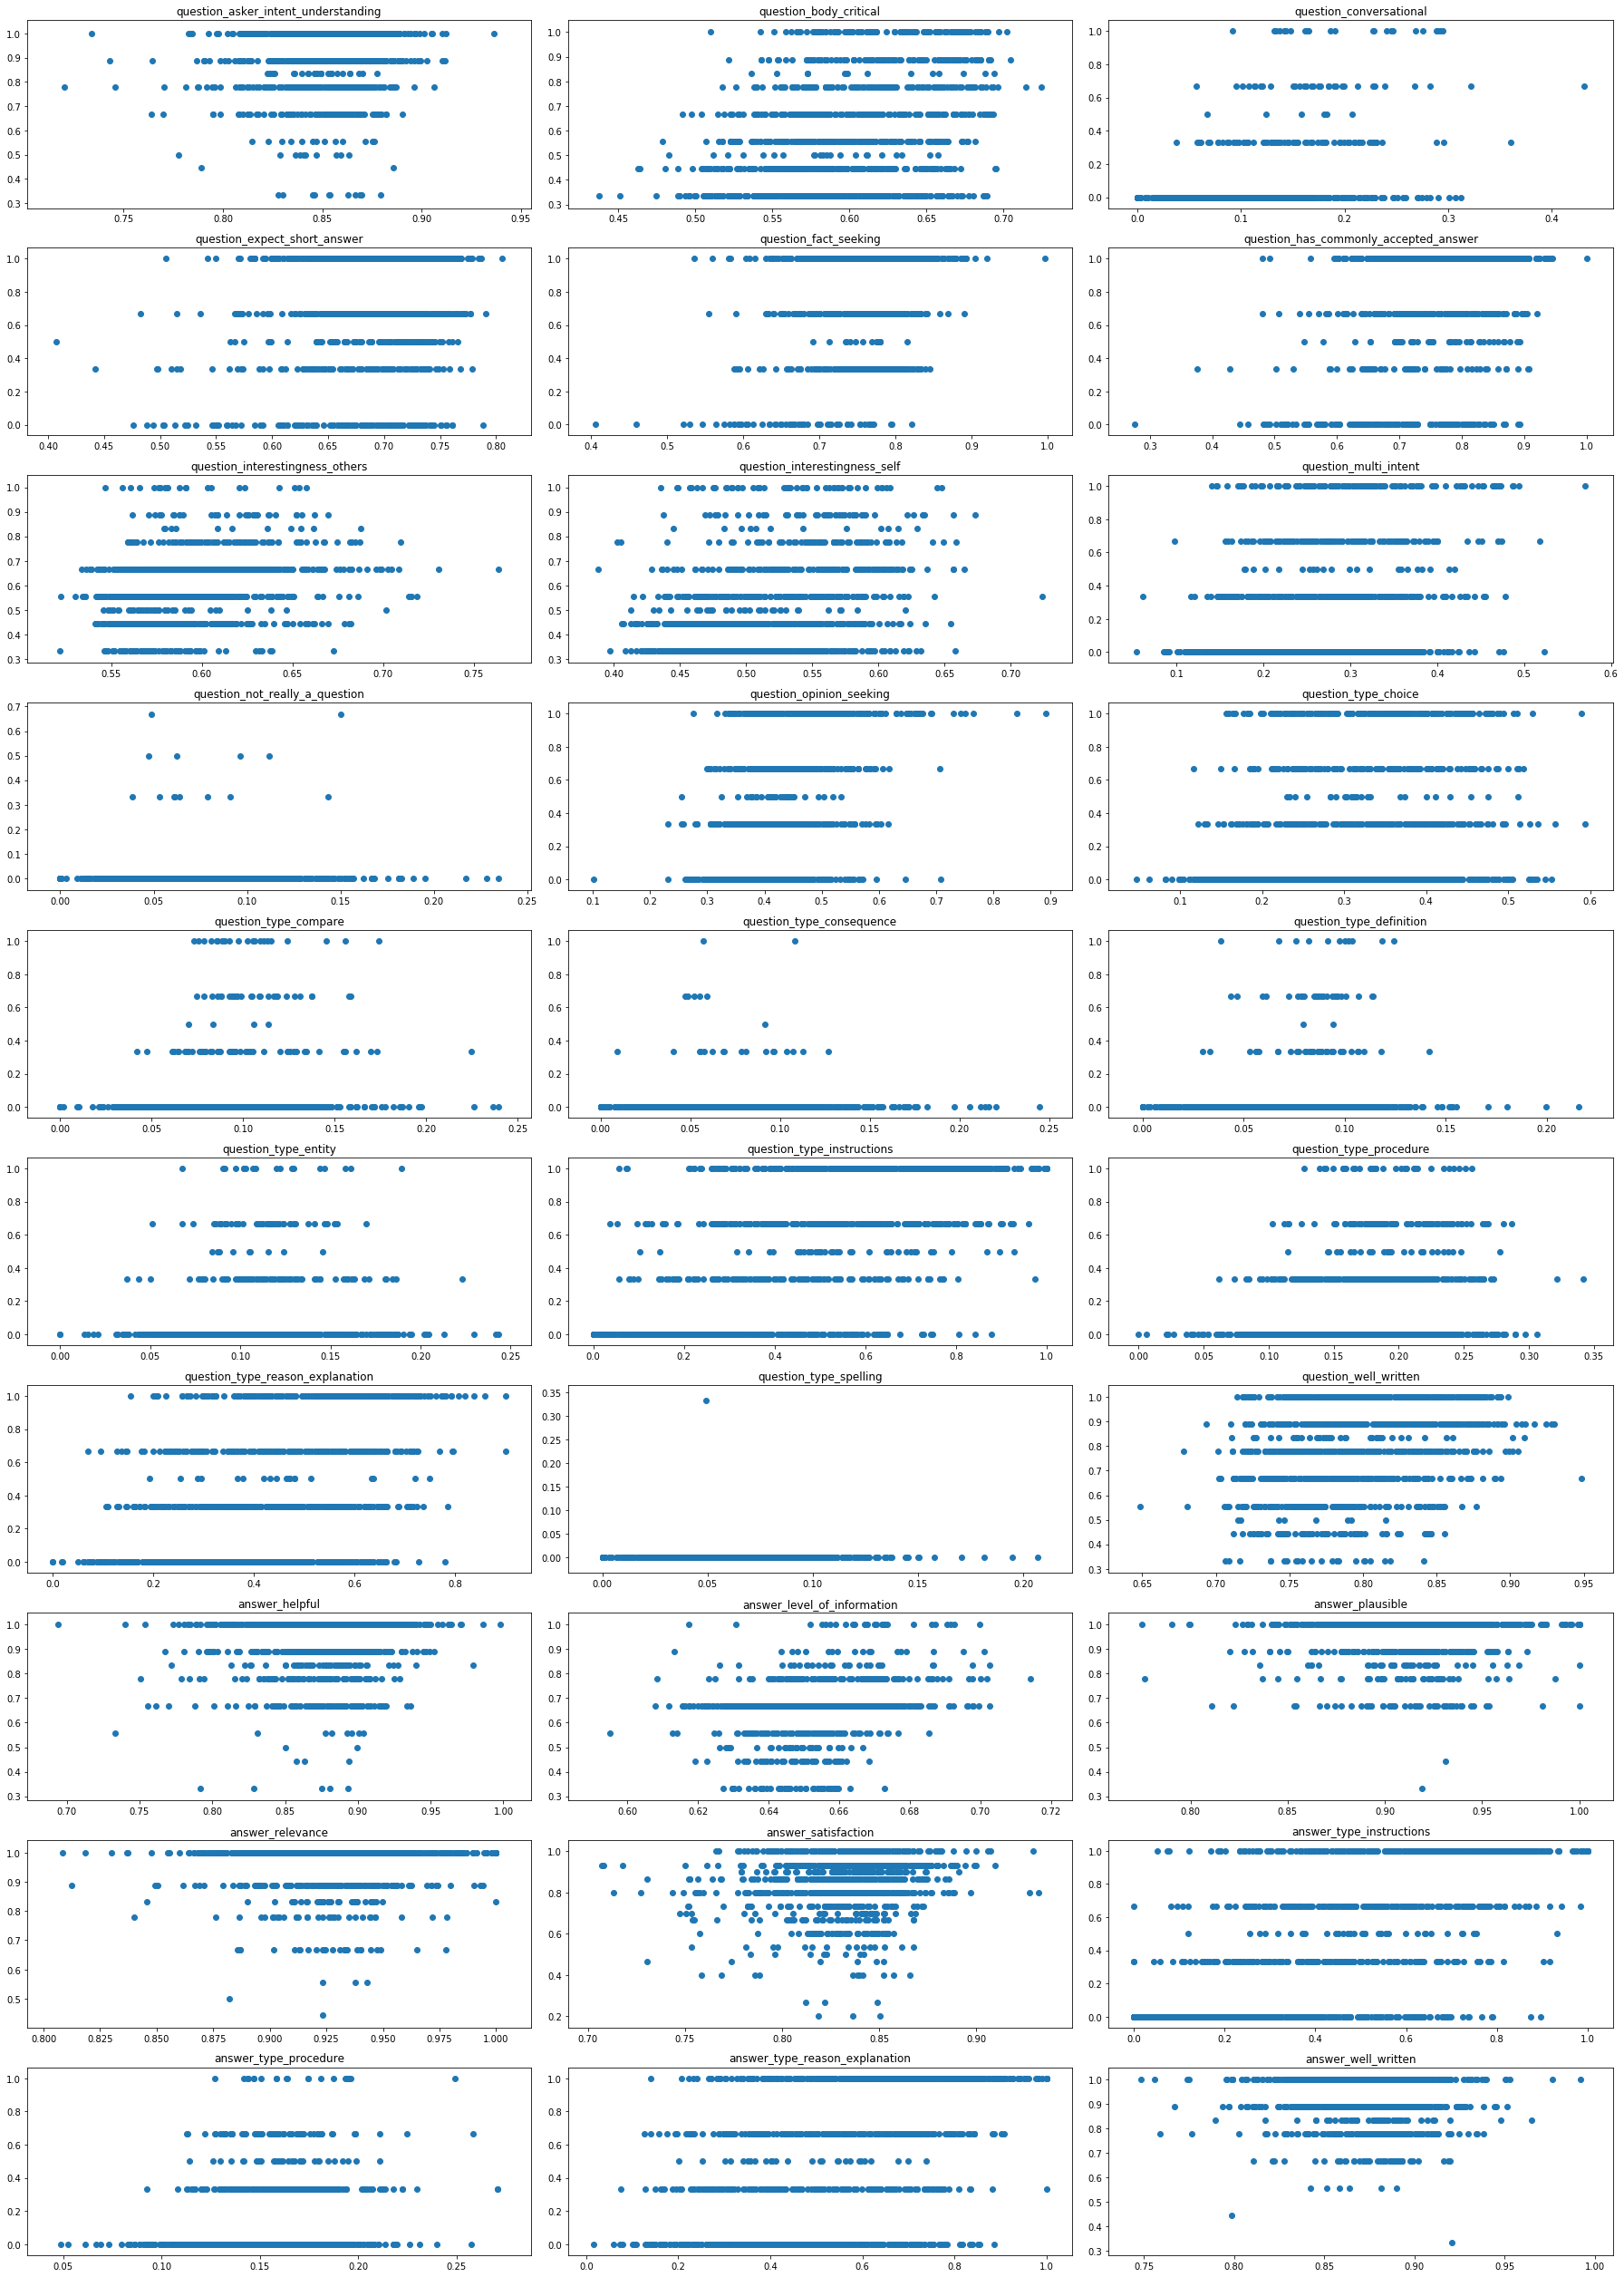

In [90]:
scatterplots(target_names, preds_test, y_test)

# Attention after LSTM

In [91]:
embedding = keras.layers.Embedding(8277, 64)

input_q = keras.layers.Input(shape=500)
x_q = embedding(input_q)
x_q = keras.layers.Bidirectional(keras.layers.LSTM(64, dropout=0.3, return_sequences=True))(x_q)
x_q = keras.layers.Attention()([x_q,x_q])
x_q = attention_many_to_one()(x_q)

input_a = keras.layers.Input(shape=500)
x_a = embedding(input_a)
x_a = keras.layers.Bidirectional(keras.layers.LSTM(64, dropout=0.3, return_sequences=True))(x_a)
x_a = keras.layers.Attention()([x_a,x_a])
x_a = attention_many_to_one()(x_a)

x = keras.layers.concatenate((x_q, x_a))

x = keras.layers.Dense(64, activity_regularizer='l2')(x)
x = keras.layers.LeakyReLU(0.5)(x)
output = keras.layers.Dense(30, activation=keras.activations.hard_sigmoid)(x)

model = keras.Model([input_q, input_a], output)

model.compile(optimizer = 'adam', loss = 'mse')

In [92]:
model.fit([X_q_train, X_a_train], y_train, batch_size=145, epochs=500, callbacks=[earlystopping], validation_data=([X_q_test, X_a_test], y_test))

Epoch 1/500
34/34 [==============================] - 10s 297ms/step - loss: 0.1518 - val_loss: 0.1375
Epoch 2/500
34/34 [==============================] - 9s 272ms/step - loss: 0.1246 - val_loss: 0.1146
Epoch 3/500
34/34 [==============================] - 9s 272ms/step - loss: 0.1061 - val_loss: 0.1006
Epoch 4/500
34/34 [==============================] - 9s 271ms/step - loss: 0.0951 - val_loss: 0.0920
Epoch 5/500
34/34 [==============================] - 9s 265ms/step - loss: 0.0881 - val_loss: 0.0864
Epoch 6/500
34/34 [==============================] - 9s 259ms/step - loss: 0.0832 - val_loss: 0.0823
Epoch 7/500
34/34 [==============================] - 9s 260ms/step - loss: 0.0795 - val_loss: 0.0795
Epoch 8/500
34/34 [==============================] - 9s 259ms/step - loss: 0.0762 - val_loss: 0.0760
Epoch 9/500
34/34 [==============================] - 9s 259ms/step - loss: 0.0731 - val_loss: 0.0739
Epoch 10/500
34/34 [==============================] - 9s 260ms/step - loss: 0.0704 - val_l

In [93]:
print_cors_mse(target_names, preds_test, y_test)

question_asker_intent_understanding:     cor: 0.11,    mse: 0.018
question_body_critical:                  cor: 0.351,    mse: 0.043
question_conversational:                 cor: 0.368,    mse: 0.031
question_expect_short_answer:            cor: 0.154,    mse: 0.121
question_fact_seeking:                   cor: 0.239,    mse: 0.083
question_has_commonly_accepted_answer:   cor: 0.35,    mse: 0.099
question_interestingness_others:         cor: 0.306,    mse: 0.018
question_interestingness_self:           cor: 0.363,    mse: 0.031
question_multi_intent:                   cor: 0.302,    mse: 0.102
question_not_really_a_question:          cor: 0.017,    mse: 0.007
question_opinion_seeking:                cor: 0.353,    mse: 0.123
question_type_choice:                    cor: 0.256,    mse: 0.131
question_type_compare:                   cor: 0.199,    mse: 0.031
question_type_consequence:               cor: 0.044,    mse: 0.009
question_type_definition:                cor: 0.133,    mse: 0.0

In [94]:
print_cors_mse(target_names, preds_train, y_train)

question_asker_intent_understanding:     cor: 0.231,    mse: 0.018
question_body_critical:                  cor: 0.374,    mse: 0.042
question_conversational:                 cor: 0.413,    mse: 0.027
question_expect_short_answer:            cor: 0.322,    mse: 0.112
question_fact_seeking:                   cor: 0.411,    mse: 0.078
question_has_commonly_accepted_answer:   cor: 0.5,    mse: 0.086
question_interestingness_others:         cor: 0.297,    mse: 0.017
question_interestingness_self:           cor: 0.389,    mse: 0.03
question_multi_intent:                   cor: 0.431,    mse: 0.095
question_not_really_a_question:          cor: 0.042,    mse: 0.007
question_opinion_seeking:                cor: 0.586,    mse: 0.104
question_type_choice:                    cor: 0.364,    mse: 0.119
question_type_compare:                   cor: 0.208,    mse: 0.023
question_type_consequence:               cor: 0.063,    mse: 0.01
question_type_definition:                cor: 0.186,    mse: 0.02


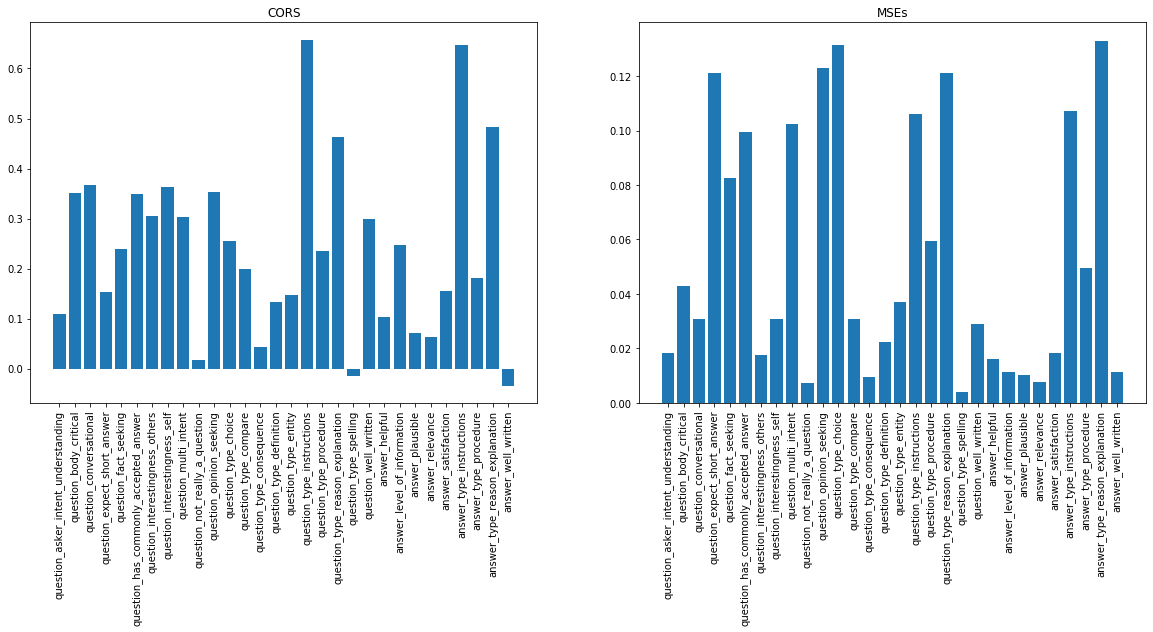

In [95]:
plot_cors_mse(target_names, preds_test, y_test)

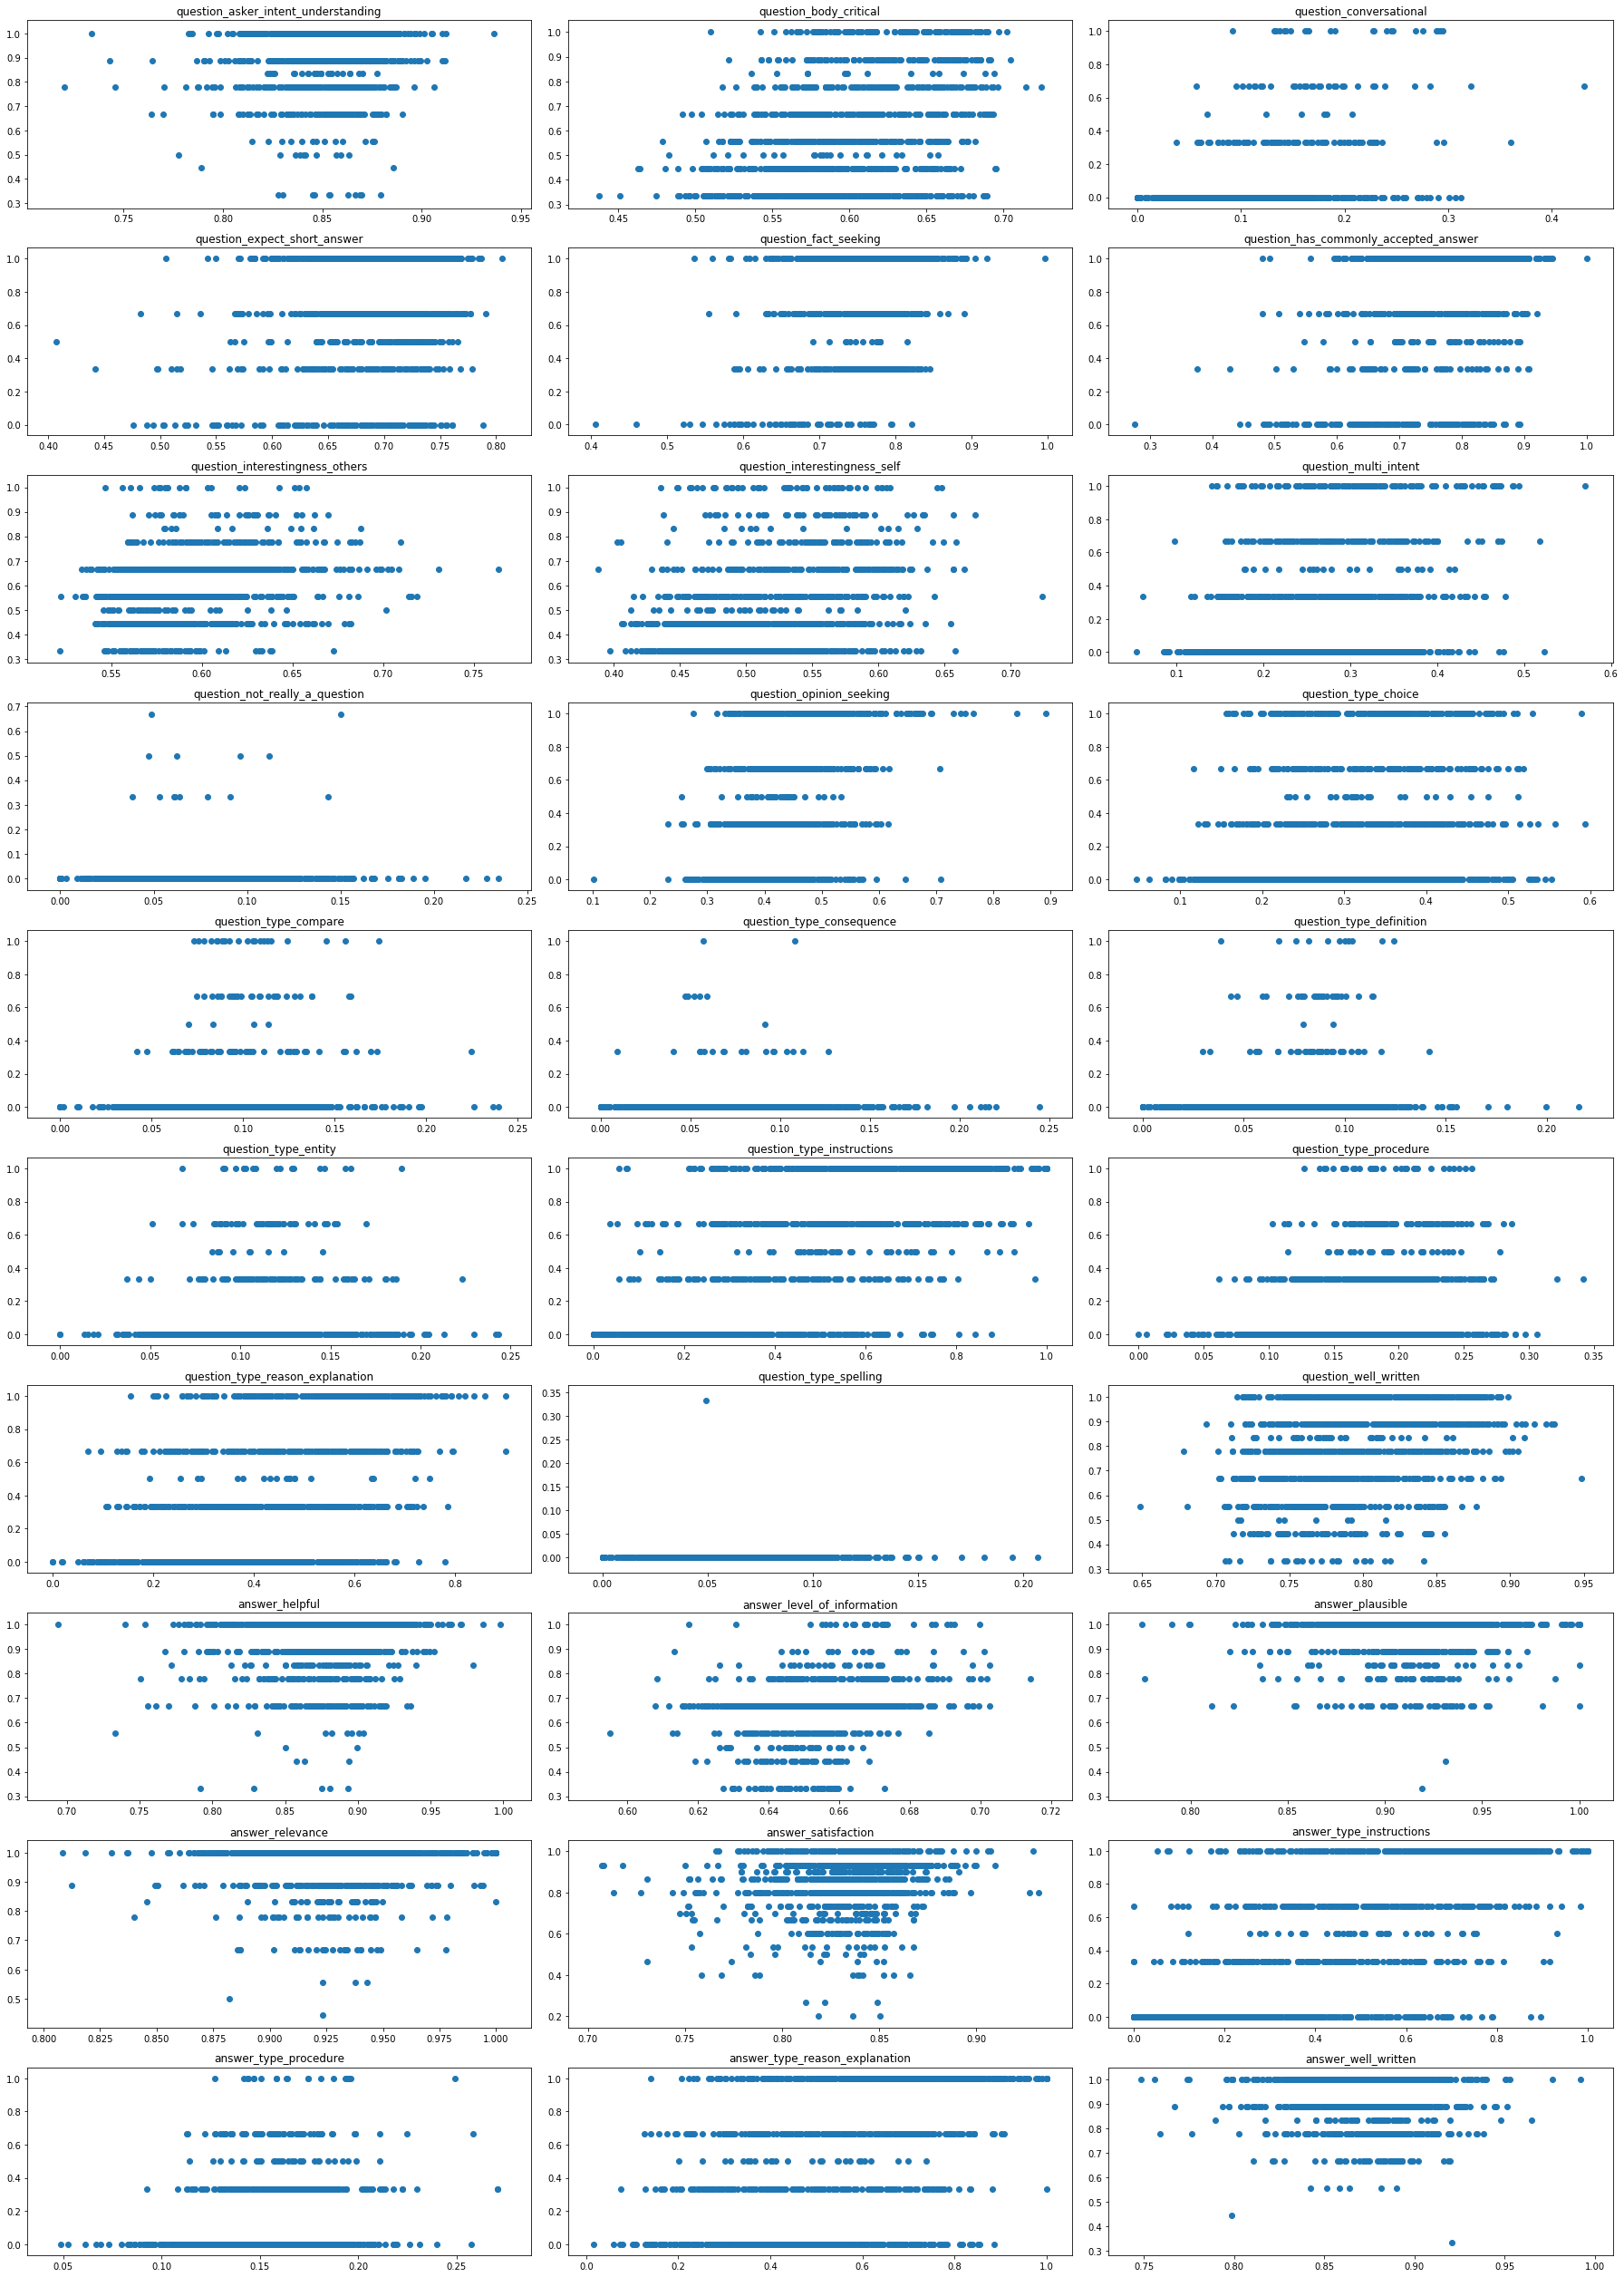

In [96]:
scatterplots(target_names, preds_test, y_test)